#### 2.3: Submission 3: Modelling and Strategy Development
* In this assignment 3, we attempt to implementing a machine trading strategy and measure its performance on unseen data against a simple buy and hold strategy.
* In previous two assignments, we used dollar bars etc. but for this third assignment we stick to regular time bars. The reason(s) for choosing so are as follows:
    - The tick data is bulky and by re-performing the task wouldn't demonstrate extra talent from out side.
    - Extracting tick, volume, dollar bars from tick data requires meeting of several dependencies - in the interest of time, we would like to focus on tasks that would yield us higher grades.
    - Offline, we examined the dollar bar data, the jarque-bera test statistic wasn't so immpressive and wouldn't yield and advantage. We therefore didn't go extra mile for this assignment.
* The dataset obtained is the standard time bar data set avaialble publicly from source like Yahoo Finance. We choose to train 7 yrs. data, i.e., 2007 - 2014; this period includes one crash which is a period of high volatility clustering. We can therefore conclude our returns data is at not type 1 stationary.

In [5]:
# We shall begin by importing requisite libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt
from sklearn.decomposition import PCA
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import stats

In [31]:
# Next, we will download 'SPDR S&P 500 ETF' NYSEArca - Nasdaq Real Time Price index in USD, data from Yahoo Finance API.
SPY = web.DataReader(name='SPY', data_source='yahoo', start=dt.date(2007,1,1), end=dt.date(2017,1,1))

In [33]:
# Next, we create a dataframe of returns from periods upto 9 days.
returns = pd.DataFrame()
for i in range(1,10):
    returns['rSPY'+str(i)] = np.log(1+SPY['Adj Close'].pct_change(periods=i))
returns.dropna(inplace=True)

In [34]:
returnsn.head()

,rSPY1,rSPY2,rSPY3,rSPY4,rSPY5,rSPY6,rSPY7,rSPY8,rSPY9
Date,,,,,,,,,
2007-01-17,0.000420,-0.001537,0.006032,0.010403,0.013729,0.012878,0.017493,0.009484,0.011605
2007-01-18,-0.003362,-0.002942,-0.004899,0.002670,0.007041,0.010367,0.009516,0.014131,0.006122
2007-01-19,0.001962,-0.001400,-0.000980,-0.002936,0.004632,0.009003,0.012329,0.011479,0.016093
2007-01-22,-0.003086,-0.001123,-0.004485,-0.004065,-0.006022,0.001547,0.005918,0.009243,0.008393
2007-01-23,0.002946,-0.000140,0.001823,-0.001539,-0.001120,-0.003076,0.004492,0.008863,0.012189


In [61]:
# Split the returns dataset into training, testing and trading datasets.
returns_train = returns[:'2014-01-01']
returns_test  = returns['2014-01-01':'2016-01-01']
returns_trade = returns['2016-01-01':]

#### Feature Selection through PCA
As the number of features grow, the amount of data required to generalize the pattern grows exponentially; this is known as **Curse of dimensionality**. As a rule of thumb, for every additonal feature may invite $>5$ training example. In already complex models that could prove to be computationally burdensome. Although 9 features in a model might not typically be considered too many, the value added by each additonal data might be diminishing and turn out to be insignificant.<br>In order to improve the accuracy of the model, we must constantly strive to keep only those features that are highly correlated with exogenous variable but are little correlated with other endogenous variables.<br> A common approach for the same is feature extraction. There are two main approaches under feature extraction, *viz*., Principal Component Analysis and Linear Discriminant analysis. For continuous data, the former is more suitable and hence we will apply PCA.
<br> PCA consists of creating linearly uncorrelated input features based on orthogonal transformation statistical procedure of possibly correlated input predictors.
<br> Steps: 
1. compute $i$ linear combinations w/out intercept:$$\sum^n_{i=1}\sum^n_{j=1}\beta_{i,j}x_i$$
2. Calculate first PC w/ max variance, constrained by sum of squared coefficients equalling one: 
\begin{align}
MAX(\sigma^2_{y_1})&=\sum^n_{i=1}\sum^n_{j=1}\beta_{1i}\beta_{1j}\sigma_{ij}\\
\text{subject to...}\sum^n_{i=1}\beta^2_{1i}&=1\\
\text{and...}\sum^n_{i=1}\sum^n_{j=1}\beta_{ni}\beta_{mj}\sigma_{ij}&=0
\end{align}
3. Calculate remaining principal component with remaining maximum variance and repeat until no varialce left.
<br>Please note that in PCA (and in other feature extraction techniques), each component consists of blended proportions of feature, i.e., loss of feature interpretability.

In [62]:
pca = PCA(n_components=None)
ret_trainpca = pca.fit_transform(returns_train.iloc[:,1:], returns_train.iloc[:,0]) #
print(f"PCA explained variance: \n{pd.Series(pca.explained_variance_ratio_, name='Explained Variance', index=range(1,len(pca.explained_variance_ratio_)+1))}")

PCA explained variance: 
1    0.794609
2    0.097654
3    0.038665
4    0.021456
5    0.016573
6    0.013498
7    0.009519
8    0.008026
Name: Explained Variance, dtype: float64


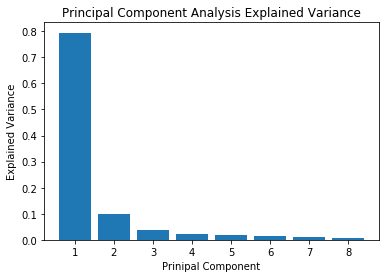

In [63]:
plt.bar(x=list(range(1,len(pca.explained_variance_ratio_)+1)), height=pca.explained_variance_ratio_)
plt.title('Principal Component Analysis Explained Variance')
plt.xlabel('Prinipal Component')
plt.ylabel('Explained Variance')
plt.show()

In [64]:
pca = PCA(n_components=2) # The first two components collectively possess major explanatory power.
ret_trainpca = pca.fit_transform(returns_train.iloc[:,1:], returns_train.iloc[:,0]) #
ret_test_pca = pca.transform(returns_test.iloc[:,1:])

#### Artificial Neural Network
ANN consists of supervised network based learning algorithm for predicting output target feature by dynamically processing output target and input predictors data through multi-layer network of optimally weighted connection of nodes. Nodes are organized in input, hidden and output layers.<br> TimeSeries Cross validation is used for lowering variance error source generated by a greater model complexity.<br> It is used for regression learning tasks which require medium to high accuracy of output prediction with moderate to slow learning time, small number of input data features and linear and non-linear relationship assumption between output and input data. ANN has following parameters:
1. Activation Function
\begin{align}
\text{Rectified Linear Unit:}\;\;
\alpha_{rlu}(z)&=MAX(0,z)\\
\text{Hyperbolic Tangent Sigmoid:}\;\;
\alpha_{hts}(z)&=tanh(z)\\
\text{Logistic Sigmoid:}\;\;
\alpha_{ls}(z)&=\frac{1}{1+e^{-z}}
\end{align}
2. Network Algorithm
3. Algorithm Optimization
\begin{align}
MIN(SSE)&=\sum^n_{i=1}(y_i-\hat{y}_{i(j)})^2\\
\hat{y}_{i(j)}&=\sum^m_{j=1}\omega_j\times \alpha(\sum^n_{i=1}\omega_i\times x_i)
\end{align}

#### Hyperparameter Tuning
From the above summary of ANN, we notice that we'll have to select the value of $\alpha$, regardless of the activation function choosen, which can influence model performance. Instead of leaving to chance, we want to select one scicntifically so as to produce the best model.<br> We therefore use the standard algorithm, Grid Search CV by invoking sklearn.model_selection.GridSearchCV(). In this standard approach, an optimum parameter is exhaustively searched, from the given choices of values for the parameter. Along with array of different values of the parameter, the ML algorithm as well as some cross-validation technique are also provided as parameters, among others.<br> GridSearchCV is not the only algorithm used for hyperparameter optimizing; Random Search, Bayesian Optimization (for noisy black-box algorithms), Gradient-Based Optimization etc. are other options available in specific cases - refer [here]('https://en.wikipedia.org/wiki/Hyperparameter_optimization') for details.
<br> <font size=1.5> sklearn.model_selection.GridSearchCV() Documentation available [here]('https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html').</font>

In [65]:
# Tuning hyperparameter alpha for Multi-Layer Perceptron model with TimeSeriesSplit 10:
CVANN = GridSearchCV(estimator=MLPRegressor(), cv=TimeSeriesSplit(n_splits=10), param_grid={"alpha": [0.0001, 0.001, 0.01, 0.101]})

CVANN.fit(X=ret_trainpca, y=returns_train.iloc[:,0])

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise',
       estimator=MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.0001, 0.001, 0.01, 0.101]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [66]:
CVANN.best_estimator_.alpha  # per the optimization, selecting alpha at 0.01 would yield best Multi-Layer Perceptron model.

0.01

In [ ]:
# Find out more about the algorithm by executing this cell:
MLPRegressor?
# Parameters are:
'''hidden_layer_sizes=(100,), activation='relu', solver='adam', alpha=0.0001, batch_size='auto', 
learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, 
random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, 
nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08'''
# We have left most of the parameters are defualts, for now. (if time permits, we will execute same algo in TensorFlow library)

In [116]:
# Fitting model to training data and predicting test and trading datasets.
ANN_train = MLPRegressor(alpha=CVANN.best_estimator_.alpha, random_state=0).fit(ret_trainpca, returns_train.iloc[:,0]) # Training
ANN_pred  = pd.DataFrame(data=ANN_train.predict(ret_trainpca), index=returns_train.index, columns=['ANN_pred']) # Test
ANN_test = pd.DataFrame(data=ANN_train.predict(ret_test_pca), index=returns_test.index, columns=['ANN_test']) # Trading

In [133]:
print(f"R-Squared: {ANN_train.score(ret_trainpca, returns_train.iloc[:,0])}")
print(f"The square for financial data is generally very low, often quite lower than what we got.")

R-Squared: 0.2938240227196274
The square for financial data is generally very low, often quite lower than what we got.


#### Performance evaluation of the ML algorithm (different from the strategy)
The most popular metric used for measuring performance of a regression problem is root mean-squared error. Assuming that the errors are gaussian and follow IID. It is computed as: $$RMSE=\sqrt{\frac{\sum^N_{i=1}(\hat{y}_i-y_i)^2}{N}}$$
where;<br>$\hat{y}_i=$ predicted output<br> $y_i=$ actual/ observed output.
<br><font size=1.7>(The gaussian assumption about the data could be contested here, but since we have no choice of data with robust statistical properties, we will stick to this dataset and assume the measures to be true)</font>
<br><font size=2.5>Note: a more robust method is time-series cross validation methods discussed in his book by Marcos Lopez De Prado - 2018. Again, we shall try to attempt if time permits.</font>

In [68]:
# Assessing model performance through mean absolute error and mean square error.
print(f"mean abs error: {mean_absolute_error(returns_test.iloc[:,0], ANN_test)}")
print(f"mean sqr error: {np.sqrt(mean_squared_error(returns_test.iloc[:,0], ANN_test))}")

mean abs error: 0.006004556841375613
mean sqr error: 0.007727814814347014


Based on R-Square and RMSE, the model training has gone satisfactory. However, that said, we shall try to come up with a better model.

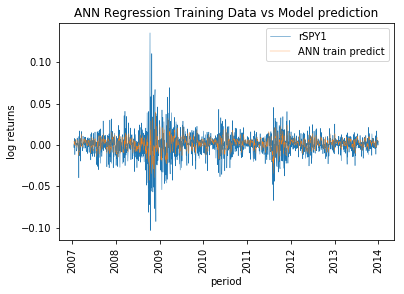

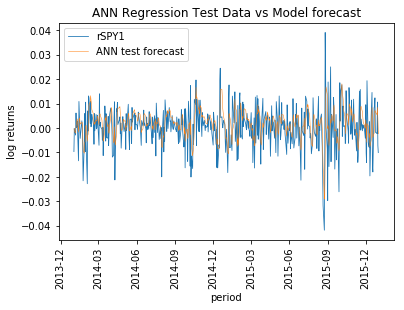

In [134]:
# Let us now plot the prediction of training and test data against the actual data: 
plt.plot(returns_train.iloc[:,0], linewidth=0.5)
plt.plot(ANN_pred, label='ANN train predict', linewidth=0.3)
plt.title('ANN Regression Training Data vs Model prediction')
plt.xlabel('period')
plt.ylabel('log returns')
plt.xticks(rotation=90)
plt.legend(loc='best')
plt.show()

plt.plot(returns_test.iloc[:,0], linewidth=0.8)
plt.plot(ANN_test, label='ANN test forecast', linewidth=0.5)
plt.title('ANN Regression Test Data vs Model forecast')
plt.xlabel('period')
plt.ylabel('log returns')
plt.xticks(rotation=90)
plt.legend(loc='best')
plt.show()

#### Machine Trading Strategies
<p style = 'text-align:justify;'>Machine trading strtegies consists of predicting output target feature by mapping its previously optimized relatioship with input predictor features which delivered highest forecasting accuracy, associated entry or exit trading signals and corrosponding trading positions. This is done within trading data subset.</p>

##### Multi-Layer perceptron method trading strategy signals
<p style = 'text-align:justify;'>Machine trading signals occur when output target feature rolling centered prediction crosses above or below its centerline. Tey are used to determine corrospond trading positions:</p>
1. Centerline Crossover Trading Signals: 
\begin{align}
\text{Buy signal:}&\;\;(\hat{y}_{i-1} - \mu_{\hat{y}_1 \rightarrow \hat{y}_{i-1}})<0\rightarrow(\hat{y}_i -\mu_{\hat{y}_1 \rightarrow \hat{y}_i})>0\\
\text{Sell signal:}&\;\;(\hat{y}_{i-1} - \mu_{\hat{y}_1 \rightarrow \hat{y}_{i-1}})>0 \rightarrow (\hat{y}_i - \mu_{\hat{y}_1 \rightarrow \hat{y}_i})<0
\end{align}
2. Machine trading positons: consists of owning or not owning asset based on associated signals.<br><font size='1.5'>For the purposes of this assignment. we shall consider long-only type positions <br>© Diego Fernandez</font>

<br>The trading strategy shall be implemented on trade data.
Previous period signal data (avoid back-testing bias).<br>
Generate trading strategy signals (buy-stock=1, sell stock=1, do nothing=0)

In [70]:
ret_pca_tra = pca.transform(returns_trade.iloc[:,1:])
ANN_trade = pd.DataFrame(data=ANN_train.predict(ret_pca_tra), index=returns_trade.index, columns=['ANN_trade'])

In [71]:
ANN_trade['ANN_trade(-1)'] = ANN_trade['ANN_trade'].shift(1)
ANN_trade['ANN_trade(-2)'] = ANN_trade['ANN_trade'].shift(2)
ANN_trade['ANN_sig'] = 0
ANN_sig = 0
for i, r in enumerate(ANN_trade.iterrows()):
    if r[1]['ANN_trade(-2)'] - np.mean(ANN_trade['ANN_trade(-2)'][0:i]) < 0 and r[1]['ANN_trade(-1)'] - np.mean(ANN_trade['ANN_trade(-1)'][0:i]) > 0:
        ANN_sig = 1
    elif r[1]['ANN_trade(-2)'] - np.mean(ANN_trade['ANN_trade(-2)'][0:i]) > 0 and r[1]['ANN_trade(-1)'] - np.mean(ANN_trade['ANN_trade(-1)'][0:i]) < 0:
        ANN_sig = -1
    else:
        0
    ANN_trade.iloc[i,3] = ANN_sig

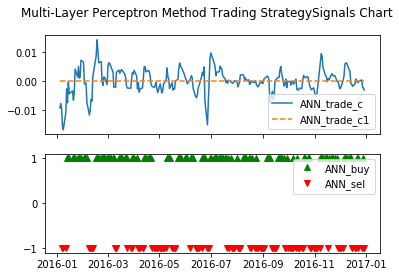

In [72]:
# Visualizing the signals
ANN_trade['ANN_trade_c'] = ANN_trade['ANN_trade'] - np.mean(ANN_trade['ANN_trade'])
ANN_trade['ANN_trade_c1']= 0
ANN_sig_c = ANN_trade['ANN_sig']
ANN_buy = ANN_sig_c[ANN_sig_c == 1]
ANN_sel = ANN_sig_c[ANN_sig_c == -1]
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot(ANN_trade['ANN_trade_c'])
ax[0].plot(ANN_trade['ANN_trade_c1'], linestyle="--")
ax[0].legend(loc='best')
ax[1].plot(ANN_buy, marker='^', linestyle='', color='g', label='ANN_buy')
ax[1].plot(ANN_sel, marker='v', linestyle='', color='r', label='ANN_sel')
ax[1].legend(loc='best')
plt.suptitle('Multi-Layer Perceptron Method Trading StrategySignals Chart')
plt.show()

##### Multi-Layer Perceptron Method Trading Strategy Positions
Machine trading positions consist of owning or not owning asset based on associated signals:
```python 
for i, r in enumerate(ANN_trade.iterrows()):
    if r[1]['ANN_sig'] == 1:
        ANN_pos = 1
    elif r[1]['ANN_sig'] == -1:
        ANN_pos = 0
    else:
        ANN_pos = ANN_trade['ANN_pos'][i-1]
    ANN_trade.iloc[i,6] = ANN_pos    
```
------

Generate trading strategy positions (long=1, short=0, strategy constraint: Long only)

In [73]:
# Code snippet to create trading position:
ANN_trade['ANN_pos'] = 0
ANN_pos = 0
for i, r in enumerate(ANN_trade.iterrows()):
    if r[1]['ANN_sig'] == 1:
        ANN_pos = 1
    elif r[1]['ANN_sig'] == -1:
        ANN_pos = 0
    else:
        ANN_pos = ANN_trade['ANN_pos'][i-1]
    ANN_trade.iloc[i,6] = ANN_pos

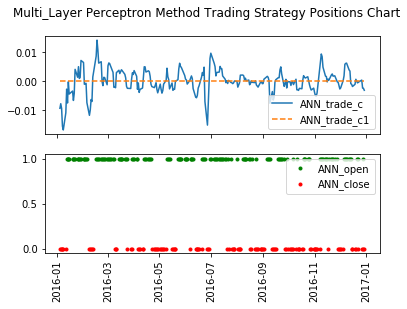

In [74]:
# Visualize the positions:
ANN_pos_c = ANN_trade['ANN_pos']
ANN_open = ANN_pos_c[ANN_pos_c == 1]
ANN_close= ANN_pos_c[ANN_pos_c == 0]
fig2, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot(ANN_trade['ANN_trade_c'])
ax[0].plot(ANN_trade['ANN_trade_c1'], linestyle="--")
ax[0].legend(loc='best')
ax[1].plot(ANN_open, marker='.', linestyle='', color='g', label='ANN_open')
ax[1].plot(ANN_close, marker='.', linestyle='', color='r', label='ANN_close')
ax[1].legend(loc='best')
plt.suptitle('Multi_Layer Perceptron Method Trading Strategy Positions Chart')
plt.xticks(rotation=90)
plt.show()

#### Machine Trading Performance:
Finally, we shall now compare the performance of crossover strategy with simple buy and hold strategy. It makes sense to go ahead with the strategy only if our MLPregression based trading strategy renders significantly better returns compared to passive investing, i.e., $\alpha$. Both strategies shall be measured along following parameters:
1. Annualized Returns: 
\begin{align}
r_i&=\ln{\frac{P_i}{P_{i-1}}}\\
r_a&=[\Pi^n_{i=1}(r_i+1)]^{\frac{252}{n}}-1
\end{align}
2. Annualized standard deviation:
\begin{align}
\sigma_{\alpha}&=\sigma\times\sqrt{252}\\
\sigma&=\sqrt{\frac{1}{n}\times\sum^n_{i=1}(r_i-\mu)^2}\\
\mu&=\frac{\sum^n_{i=1}r_i}{n}
\end{align}
3. Annualized Sharpe Ratio:
\begin{align}
S_{a}&=\frac{r_a-rf_a}{\sigma_a}
\end{align}
To make it more realistic, we shall also include strategy performance after deducting brokerage commissions. 

In [75]:
# Multi-Layer Perceptron method strategy daily returns w/out commissions
ANN_trade['ANN_d_ret'] = returns_trade.iloc[:,0] * ANN_trade['ANN_pos']

In [76]:
# Multi-Layer Perceptron method strategy daily returns w/ commissions
ANN_trade['ANN_pos(-1)'] = ANN_trade['ANN_pos'].shift(1)
ANN_trade['ANN_tc'] = 0
ANN_tc = 0
for i, r in enumerate(ANN_trade.iterrows()):
    if (r[1]['ANN_sig']==1 or r[1]['ANN_sig']==-1) and (r[1]['ANN_pos'] != r[1]['ANN_pos(-1)']):
        ANN_tc = 0.001
    else:
        ANN_tc = 0.000
    ANN_trade.iloc[i,9] = ANN_tc

ANN_trade['ANN_d_ret_c'] = (returns_trade.iloc[:,0] * ANN_trade['ANN_pos']) - ANN_trade['ANN_tc']

In [77]:
# Multi-Layer Perceptron Method Trading Strategy Cumulative returns
ANN_trade['cumret'] = np.cumprod(ANN_trade['ANN_d_ret'] + 1) - 1
ANN_trade['cumret_c'] = np.cumprod(ANN_trade['ANN_d_ret_c'] + 1) - 1
ANN_trade['SPY_ret_c'] = np.cumprod(returns.iloc[:,0] + 1) - 1

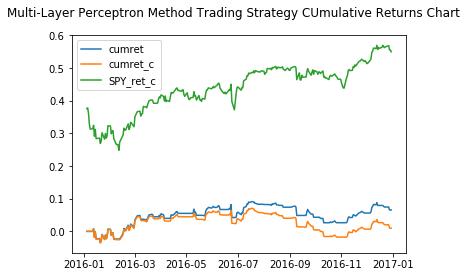

In [78]:
plt.plot(ANN_trade['cumret'])
plt.plot(ANN_trade['cumret_c'])
plt.plot(ANN_trade['SPY_ret_c'])
plt.legend(loc='best')
plt.suptitle('Multi-Layer Perceptron Method Trading Strategy CUmulative Returns Chart')
plt.show()

In [79]:
# Strategy annualized returns
print(f"ann_rets = {ANN_trade.iloc[-1,11]}")
print(f"ann_rets_c = {ANN_trade.iloc[-1,12]}")
print(f"ann_rets_SPY = {ANN_trade.iloc[-1,13]}")

ann_rets = 0.06555645085418327
ann_rets_c = 0.009541453141573397
ann_rets_SPY = 0.5495305966748054


In [80]:
print(f"ann_sd = {np.std(ANN_trade['ANN_d_ret']) * np.sqrt(252)}")
print(f"ann_sd_c = {np.std(ANN_trade['ANN_d_ret_c']) * np.sqrt(252)}")
print(f"ann_sd_SPY = {np.std(returns_trade.iloc[:,0]) * np.sqrt(252)}")

ann_sd = 0.1053190839231448
ann_sd_c = 0.1054017475781623
ann_sd_SPY = 0.13052086586412853


In [81]:
# Assuming risk-free rate to be 0, calculating annualized sharpe ratio:
print(f"{ANN_trade.iloc[-1,11]/(np.std(ANN_trade['ANN_d_ret']) * np.sqrt(252))}")
print(f"{ANN_trade.iloc[-1,12]/(np.std(ANN_trade['ANN_d_ret_c']) * np.sqrt(252))}")
print(f"{ANN_trade.iloc[-1,13]/(np.std(returns_trade.iloc[:,0]) * np.sqrt(252))}")

0.6224555741675669
0.09052461994994708
4.210289236411162


Our strategy has rendered very poor performance when compared with simple buy and hold strategy (passive investing). This signifies that although a well performing model need not necessarily translate in a profitable strategy. In his book, the author Marcos Lopez De Prado - 2018, describes several pitfall one must be mindful of while developing machine trading strategies:
1. The data structure - he arges that the alternate structures aggregated based on *viz*., trade, volume, dollar amount etc. possess better statistical charecteristics. The data we used to train/ test/ implement out model was regular fixed time interval aggregated data, which, though supposed to be gaussian and IID, is not.
2. Returns data gains stationarity at cost of information. Pricing data contains information, i.e., in quant domain we can't assume data to be IID. It is recommended by the author to partially differnentiate the data to loose unnecessary serial corraltion yet retain most of the information constined in raw price data.
3. Features we selected were merely lags of the returns data that was already laccking information (ref: #2 above) Perhaps other features could be used, viz., certain macro factors like interest rates, CPI index, housing price etc.
4. Trained just single model and haven't cross-validated. In reality, it is recommended to have an ensemble of several models with an average cv score, rather than having just one model with a single score.